In [1]:
import argparse
from argparse import Namespace 
import torch
from torchmdnet import calculators
from torchmdnet.utils import LoadFromFile, LoadFromCheckpoint, save_argparse, number
from torchmdnet import datasets, priors, models
from torchmdnet.data import DataModule
from torchmdnet.models import output_modules
from torchmdnet.models.utils import rbf_class_mapping, act_class_mapping
from torchmdnet.models.model import load_model, create_model

from moleculekit.molecule import Molecule
from torchmd.forcefields.ff_yaml import YamlForcefield
from torchmd.forcefields.forcefield import ForceField
from torchmd.forces import Forces
from torchmd.integrator import Integrator, maxwell_boltzmann
from torchmd.parameters import Parameters
from torchmd.systems import System
from torchmd.wrapper import Wrapper

from torchmdexp.nn.utils import get_embeddings
from torchmdexp.nn.module import LNNP
from torchmdexp.nn.calculator import External

from tqdm import tqdm

## Load args file

In [2]:
def get_args():
    # fmt: off
    parser = argparse.ArgumentParser(description='Training')
    parser.add_argument('--load-model', action=LoadFromCheckpoint, help='Restart training using a model checkpoint')  # keep first
    parser.add_argument('--conf', '-c', type=open, action=LoadFromFile, help='Configuration yaml file')  # keep second
    parser.add_argument('--num-epochs', default=300, type=int, help='number of epochs')
    parser.add_argument('--batch-size', default=32, type=int, help='batch size')
    parser.add_argument('--inference-batch-size', default=None, type=int, help='Batchsize for validation and tests.')
    parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
    parser.add_argument('--lr-patience', type=int, default=10, help='Patience for lr-schedule. Patience per eval-interval of validation')
    parser.add_argument('--lr-min', type=float, default=1e-6, help='Minimum learning rate before early stop')
    parser.add_argument('--lr-factor', type=float, default=0.8, help='Minimum learning rate before early stop')
    parser.add_argument('--lr-warmup-steps', type=int, default=0, help='How many steps to warm-up over. Defaults to 0 for no warm-up')
    parser.add_argument('--early-stopping-patience', type=int, default=30, help='Stop training after this many epochs without improvement')
    parser.add_argument('--weight-decay', type=float, default=0.0, help='Weight decay strength')
    parser.add_argument('--ema-alpha-y', type=float, default=1.0, help='The amount of influence of new losses on the exponential moving average of y')
    parser.add_argument('--ema-alpha-dy', type=float, default=1.0, help='The amount of influence of new losses on the exponential moving average of dy')
    parser.add_argument('--ngpus', type=int, default=-1, help='Number of GPUs, -1 use all available. Use CUDA_VISIBLE_DEVICES=1, to decide gpus')
    parser.add_argument('--num-nodes', type=int, default=1, help='Number of nodes')
    parser.add_argument('--precision', type=int, default=32, choices=[16, 32], help='Floating point precision')
    parser.add_argument('--log-dir', '-l', default='/trainings', help='log file')
    parser.add_argument('--splits', default=None, help='Npz with splits idx_train, idx_val, idx_test')
    parser.add_argument('--train-size', type=number, default=None, help='Percentage/number of samples in training set (None to use all remaining samples)')
    parser.add_argument('--val-size', type=number, default=0.05, help='Percentage/number of samples in validation set (None to use all remaining samples)')
    parser.add_argument('--test-size', type=number, default=0.1, help='Percentage/number of samples in test set (None to use all remaining samples)')
    parser.add_argument('--test-interval', type=int, default=10, help='Test interval, one test per n epochs (default: 10)')
    parser.add_argument('--save-interval', type=int, default=10, help='Save interval, one save per n epochs (default: 10)')
    parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')
    parser.add_argument('--distributed-backend', default='ddp', help='Distributed backend: dp, ddp, ddp2')
    parser.add_argument('--num-workers', type=int, default=4, help='Number of workers for data prefetch')
    parser.add_argument('--redirect', type=bool, default=False, help='Redirect stdout and stderr to log_dir/log')
    
    # model architecture
    parser.add_argument('--model', type=str, default='graph-network', choices=models.__all__, help='Which model to train')
    parser.add_argument('--output-model', type=str, default='Scalar', choices=output_modules.__all__, help='The type of output model')
    parser.add_argument('--prior-model', type=str, default=None, choices=priors.__all__, help='Which prior model to use')

    # architectural args
    parser.add_argument('--embedding-dimension', type=int, default=256, help='Embedding dimension')
    parser.add_argument('--num-layers', type=int, default=6, help='Number of interaction layers in the model')
    parser.add_argument('--num-rbf', type=int, default=64, help='Number of radial basis functions in model')
    parser.add_argument('--num-filters', type=int, default=128, help='Number of filters in model')    
    parser.add_argument('--activation', type=str, default='silu', choices=list(act_class_mapping.keys()), help='Activation function')
    parser.add_argument('--rbf-type', type=str, default='expnorm', choices=list(rbf_class_mapping.keys()), help='Type of distance expansion')
    parser.add_argument('--trainable-rbf', type=bool, default=False, help='If distance expansion functions should be trainable')
    parser.add_argument('--neighbor-embedding', type=bool, default=False, help='If a neighbor embedding should be applied before interactions')
    
    # dataset specific
    parser.add_argument('--data_dir', default=None, help='Input directory')
    parser.add_argument('--dataset', default=None, type=str, choices=datasets.__all__, help='Name of the torch_geometric dataset')
    parser.add_argument('--dataset-root', default='~/data', type=str, help='Data storage directory (not used if dataset is "CG")')
    parser.add_argument('--dataset-arg', default=None, type=str, help='Additional dataset argument, e.g. target property for QM9 or molecule for MD17')
    parser.add_argument('--coord-files', default=None, type=str, help='Custom coordinate files glob')
    parser.add_argument('--embed-files', default=None, type=str, help='Custom embedding files glob')
    parser.add_argument('--energy-files', default=None, type=str, help='Custom energy files glob')
    parser.add_argument('--force-files', default=None, type=str, help='Custom force files glob')
    parser.add_argument('--energy-weight', default=1.0, type=float, help='Weighting factor for energies in the loss function')
    parser.add_argument('--force-weight', default=1.0, type=float, help='Weighting factor for forces in the loss function')

    # Transformer specific
    parser.add_argument('--distance-influence', type=str, default='both', choices=['keys', 'values', 'both', 'none'], help='Where distance information is included inside the attention')
    parser.add_argument('--attn-activation', default='silu', choices=list(act_class_mapping.keys()), help='Attention activation function')
    parser.add_argument('--num-heads', type=int, default=8, help='Number of attention heads')
    
    # Torchmdexp specific
    parser.add_argument('--device', default='cpu', help='Type of device, e.g. "cuda:1"')
    parser.add_argument('--forcefield', default="../data/ca_priors-dihedrals_general_2xweaker.yaml", help='Forcefield .yaml file')
    parser.add_argument('--forceterms', nargs='+', default="bonds", help='Forceterms to include, e.g. --forceterms Bonds LJ')
    parser.add_argument('--cutoff', default=None, type=float, help='LJ/Elec/Bond cutoff')
    parser.add_argument('--rfa', default=False, action='store_true', help='Enable reaction field approximation')
    parser.add_argument('--replicas', type=int, default=1, help='Number of different replicas to run')
    parser.add_argument('--step_update', type=int, default=5, help='Number of epochs to update the simulation steps')
    parser.add_argument('--switch_dist', default=None, type=float, help='Switching distance for LJ')
    parser.add_argument('--temperature',  default=300,type=float, help='Assign velocity from initial temperature in K')
    parser.add_argument('--force-precision', default='single', type=str, help='LJ/Elec/Bond cutoff')
    parser.add_argument('--verbose', default=None, help='Add verbose')
    parser.add_argument('--timestep', default=1, type=float, help='Timestep in fs')
    parser.add_argument('--langevin_gamma',  default=0.1,type=float, help='Langevin relaxation ps^-1')
    parser.add_argument('--langevin_temperature',  default=0,type=float, help='Temperature in K of the thermostat')
    parser.add_argument('--max_steps',type=int,default=2000,help='Total number of simulation steps')
    
    # other args
    parser.add_argument('--derivative', default=True, type=bool, help='If true, take the derivative of the prediction w.r.t coordinates')
    parser.add_argument('--cutoff-lower', type=float, default=0.0, help='Lower cutoff in model')
    parser.add_argument('--cutoff-upper', type=float, default=5.0, help='Upper cutoff in model')
    parser.add_argument('--atom-filter', type=int, default=-1, help='Only sum over atoms with Z > atom_filter')
    
    parser.add_argument('--max-z', type=int, default=100, help='Maximum atomic number that fits in the embedding matrix')
    parser.add_argument('--max-num-neighbors', type=int, default=32, help='Maximum number of neighbors to consider in the network')
    parser.add_argument('--standardize', type=bool, default=False, help='If true, multiply prediction by dataset std and add mean')
    parser.add_argument('--reduce-op', type=str, default='add', choices=['add', 'mean'], help='Reduce operation to apply to atomic predictions')

    args = parser.parse_args("")
    all_defaults = {}
    for key in vars(args):
        all_defaults[key] = parser.get_default(key)
    
    return all_defaults

In [3]:
args_dict = get_args()

In [4]:
# process_yaml.py file
import yaml

with open('../arguments/cln_gnn_brd.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    args_file = yaml.load(file, Loader=yaml.FullLoader)
for key, value in args_file.items():
    args_dict[key] = value
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)
args = Struct(**args_dict)

In [5]:
def get_native_coords(mol, args):
    
    replicas = args.replicas
    device = args.device
    pos = torch.zeros(replicas, mol.numAtoms, 3, device = device)
    
    atom_pos = np.transpose(mol.coords, (2, 0, 1))
    if replicas > 1 and atom_pos.shape[0] != replicas:
        tom_pos = np.repeat(atom_pos[0][None, :], replicas, axis=0)

    pos[:] = torch.tensor(
            atom_pos, dtype=pos.dtype, device=pos.device
    )
    pos = pos.type(torch.float64)
    
    return pos

In [6]:
import numpy as np
mol = Molecule('../data/chignolin_cln025.pdb')
mol.read('../data/chignolin_cln025.psf')
mol.filter('name CA')
args.replicas = 1
pos = get_native_coords(mol, args)
args.device = 'cuda:0'

## Train

In [7]:
n_epochs = 5000
steps = 250
output_period = 1
native_coords = get_native_coords(mol, args)

In [8]:
trained_lambda_net = '/workspace2/fast_folders_cgnet/multiprotein/single_prot_fix/lambda/train_geom_lambda_dih_4int_fix_rep1/epoch=85-val_loss=736.1273-test_loss=21.5217.ckpt'
model = load_model(trained_lambda_net, device='cuda:1', derivative=True)
embeddings = get_embeddings(mol)
embeddings = torch.tensor(embeddings, device = args.device).repeat(args.replicas, 1)
external = External(model, embeddings, device = args.device, mode = 'train')

In [9]:
ff = ForceField.create(mol,args.forcefield)
parameters = Parameters(ff, mol, terms=args.forceterms, device=args.device)
forces = Forces(parameters, terms=args.forceterms, external=external, cutoff=args.cutoff, 
                rfa=args.rfa, switch_dist=args.switch_dist
                )

In [10]:
system = System(mol.numAtoms, nreplicas=args.replicas,precision=torch.double, device=args.device)
system.set_positions(mol.coords)
system.set_box(mol.box)
system.set_velocities(maxwell_boltzmann(forces.par.masses, T=args.temperature, replicas=args.replicas))

In [11]:
from statistics import mean

def simulator(native_coords, system, forces, steps, output_period, timestep, replicas, 
              device = 'cuda:1', gamma=None, langevin_temperature=None
             ):
    
    integrator = Integrator(system, forces, timestep, device, gamma=gamma, T=langevin_temperature)
    integrator.forces.external.mode = 'train'
    #iterator = tqdm(range(1,int(steps/output_period)+1))
    iterator = range(1,int(steps/output_period)+1)
    Epot = forces.compute(system.pos, system.box, system.forces)
    
    loss = 0
    rmsds = []
    for i in iterator:
        if ((i // 250) % 2) == 0:
            integrator.forces.external.mode = 'train'
        else:
            pos_rmsd, _ = rmsd(native_coords, system.pos)
            loss += torch.log(pos_rmsd + 1.0)
            rmsds.append(pos_rmsd.item())
            
            integrator.forces.external.mode = 'val'
            
        Ekin, Epot, T = integrator.step(niter=output_period)
    
    mean_rmsd = mean(rmsds)
    loss /= len(rmsds)
    return loss, mean_rmsd

In [12]:
from torchmdexp.nn.utils import rmsd
import matplotlib.pyplot as plt

optim = torch.optim.Adam(external.model.parameters(), lr=0.0001)

rmsds = []
epochs = []

for epoch in range(n_epochs):
    
    embeddings = get_embeddings(mol)
    embeddings = torch.tensor(embeddings, device = args.device).repeat(args.replicas, 1)
    external = External(model, embeddings, device = args.device, mode = 'train')
    
    ff = ForceField.create(mol,args.forcefield)
    parameters = Parameters(ff, mol, terms=args.forceterms, device=args.device)
    forces = Forces(parameters, terms=args.forceterms, external=external, cutoff=args.cutoff, 
                    rfa=args.rfa, switch_dist=args.switch_dist
                    )
    
    system = System(mol.numAtoms, nreplicas=args.replicas,precision=torch.double, device=args.device)
    system.set_positions(mol.coords)
    system.set_box(mol.box)
    system.set_velocities(maxwell_boltzmann(forces.par.masses, T=args.temperature, replicas=args.replicas))
    
    loss, mean_rmsd = simulator(native_coords, system, forces, steps, output_period, args.timestep, args.replicas, device=args.device, 
        gamma=args.langevin_gamma, langevin_temperature=args.langevin_temperature
       )
        
    rmsds.append(mean_rmsd)
    epochs.append(epoch)
    
    optim.zero_grad()
    loss.backward
    optim.step()
    
    print(f"EPOCH {epoch}: loss = {loss} ; rmsd = {mean_rmsd}")

EPOCH 0: loss = 0.8585669343426414 ; rmsd = 1.3597765546986815
EPOCH 1: loss = 0.9056372450852846 ; rmsd = 1.4735076515358898
EPOCH 2: loss = 0.8322852761431548 ; rmsd = 1.2985655998480041
EPOCH 3: loss = 0.8550897084529696 ; rmsd = 1.3515853281946866
EPOCH 4: loss = 0.7415521155888781 ; rmsd = 1.0991911746065102
EPOCH 5: loss = 0.7295125578068051 ; rmsd = 1.074069372311076
EPOCH 6: loss = 0.8442924913054125 ; rmsd = 1.3263313325444754
EPOCH 7: loss = 0.8702218637574928 ; rmsd = 1.3874404812854702
EPOCH 8: loss = 0.6593191857325684 ; rmsd = 0.9334755484704399
EPOCH 9: loss = 0.7461110492713493 ; rmsd = 1.1087830958115978
EPOCH 10: loss = 0.736957535810988 ; rmsd = 1.0895683965247236
EPOCH 11: loss = 0.7125211759282182 ; rmsd = 1.0391257782401342
EPOCH 12: loss = 0.6390249848470387 ; rmsd = 0.8946326828665104
EPOCH 13: loss = 0.9074266416760086 ; rmsd = 1.4779377000694867
EPOCH 14: loss = 0.8604182798083263 ; rmsd = 1.3641493628635606
EPOCH 15: loss = 0.8542119633073061 ; rmsd = 1.34952

KeyboardInterrupt: 

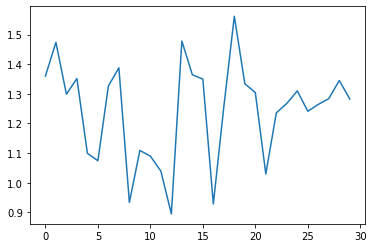

In [13]:
plt.plot(epochs, rmsds)